In [1]:
"""
  A manager that facilitates reading and writing files to GCP Storage
"""
import logging
import os
import subprocess
from io import BytesIO
from typing import List, Dict, Callable, Tuple, Union
from mypy_extensions import TypedDict

from google.cloud import storage # type: ignore

def get_path_prefix(root_dir: str, relative_path: str) -> str:
    prefix = ''
    if root_dir:
        prefix = root_dir.rstrip('/') + '/'

    if relative_path and relative_path != '/':
        prefix = prefix + relative_path.strip('/') + '/'

    return prefix

class PathNode(TypedDict, total=False):
    name: str
    type: str
    size: float
        
class GCPStorageManager(object):

    def __init__(self, storage_details: Dict, verbose: bool) -> None:
        self._bucket_name = storage_details.get('bucket')
        self._root_dir = storage_details.get('root')
        self.client = storage.Client()
        self.verbose = verbose

    def _abs_path(self, rel_path: str) -> str:
        if not self._root_dir:
            return rel_path

        return os.path.join(self._root_dir, rel_path)

    def _build_current_url(self) -> str:
        if self._root_dir:
            return "https://console.cloud.google.com/storage/browser/" + self._bucket_name + "/" + self._root_dir
        else:
            return "https://console.cloud.google.com/storage/browser/" + self._bucket_name

    def get_root_dir(self) -> str:
        return self._root_dir

    def get_storage_details(self) -> Dict:
        return {
            'provider': file_utils.ProviderList.GCP_STORAGE,
            'bucket': self._bucket_name,
            'root': self._root_dir
        }

    def get_sync_login_command(self, env_vars: Dict) -> List[str]:
        return None

    def get_sync_url(self, path: str) -> str:
        if not path or path == '/':
            abs_path = self._root_dir
        else:
            abs_path = self._abs_path(path)
        return f'gs://{self._bucket_name}/{abs_path}'

    def get_sync_command(self, src_dir: str, remote_path: str) -> Callable:

        def sync_call() -> Tuple[int, str]:
            cmd = ['gsutil', 'rsync', '-r', src_dir, self.get_sync_url(remote_path)]
            p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout, stderr = p.communicate()
            err_code = 0
            stderr_val = ''

            if p.returncode != 0:
                logging.error('Copy response is: {}'.format(stderr.decode('utf-8')))
                stderr_val = stderr.decode('utf-8')
                err_code = p.returncode

            return err_code, stderr_val

        return sync_call

    def rm_file(self, relative_path: str) -> None:
        bucket = self.client.bucket(self._bucket_name)
        path = self._abs_path(relative_path)
        blob = bucket.blob(path)
        logging.info('Deleting file at ' + path)
        blob.delete()

    def rm_dir(self, relative_path: str) -> None:
        bucket = self.client.bucket(self._bucket_name)
        prefix = get_path_prefix(self._root_dir, relative_path)
        blob = bucket.blob(prefix)
        logging.info('Deleting files at ' + prefix)
        blob.delete()

    def read_content(self, path: str, throw_exception: bool, read_range: str = None, streaming: bool = False) -> bytes:
        try:
            path = self._abs_path(path)
            bucket = self.client.bucket(self._bucket_name)
            blob = bucket.blob(path)
            result = blob.download_as_bytes()

            if self.verbose:
                logging.info(f"Downloading content from {self._build_current_url()}/{path}")

            return result
        except Exception as e:
            raise

    #def gen_presigned_url(self, path: str) -> str:
    #    # dask and other frameworks explicit s3 link rather than a byte stream or contet (e.g. s3://bucket/foo.csv)
    #    return self._s3.generate_presigned_url('get_object',
    #                                           Params={'Bucket': self._bucket_name, 'Key': self._abs_path(path)})

    # Checks to see if the job directory exists.  No side-effects.
    def check_dir_exists(self, path: str) -> bool:
        # Create the prefix for this particular job.
        exists = False
        prefix = get_path_prefix(self._root_dir, path)
        blobs = list(self.client.list_blobs(
            self._bucket_name, prefix=prefix
        ))
        if len(blobs) > 0:
            exists = True

        return exists

    def _download_content(self, remote_path: str) -> bytes:
        remote_path = self._abs_path(remote_path)
        bucket = self.client.bucket(self._bucket_name)
        blob = bucket.blob(remote_path)
        if self.verbose:
            logging.info(f"Downloading content from {self._build_current_url()}/{remote_path}")

        fileobj = BytesIO()
        blob.download_to_file(fileobj)
        return fileobj.getvalue()

    def download_file(self, remote_path: str, file_name: str) -> None:
        # Move references to large data items across folders
        remote_path = self._abs_path(remote_path)
        bucket = self.client.bucket(self._bucket_name)
        blob = bucket.blob(remote_path)
        if self.verbose:
            logging.info(f"Downloading file {self._build_current_url()}/{remote_path} to {file_name}")

        dirname = os.path.dirname(file_name)

        if dirname:
            # Only create a directory if it's not ''
            if not os.path.exists(dirname):
                os.makedirs(dirname)

        blob.download_to_filename(file_name)

    def download_and_unzip(self, remote_path: str, local_dir: str) -> None:
        zip_bytes = self._download_content(remote_path)
        file_utils.unzip_into_dir(zip_bytes, local_dir)

    def download_dir(self, remote_path: str, local_path: str) -> int:
        nFiles = 0
        if self.verbose:
            logging.info("Downloading folder: " + remote_path + " to " + local_path)

        prefix = file_utils.get_path_prefix(self._root_dir, remote_path)
        for blob in self.client.list_blobs(self._bucket_name, prefix=prefix):
            if blob.name.endswith('/'):
                continue

            rel_path = os.path.relpath(blob.name, prefix)
            dest_pathname = os.path.join(local_path, rel_path)

            if not os.path.exists(os.path.dirname(dest_pathname)):
                os.makedirs(os.path.dirname(dest_pathname))

            if self.verbose:
                logging.info(f"Downloading file {blob.name} to {dest_pathname}")

            blob.download_to_filename(dest_pathname)  # Download
            nFiles += 1

        return nFiles

    def upload_content(self, content: bytes, file_name: str) -> None:
        # Uploads file content to a specific filename location
        bucket = self.client.bucket(self._bucket_name)
        if self.verbose:
            logging.info(f"Uploading content to {self._build_current_url()}/{file_name}")

        blob = bucket.blob(self._abs_path(file_name))
        blob.upload_from_file(BytesIO(content))

    def list_directory(self, path: str, with_size: bool = False) -> Dict:
        prefix = get_path_prefix(self._root_dir, path)
        bucket = self.client.bucket(self._bucket_name)
        blobs = bucket.list_blobs(prefix=prefix)
        nodes = []
        for blob in blobs:
            if blob.name.endswith('/'):
                nodes.append(PathNode(name=os.path.basename(blob.name[:-1]), type='folder'))
            else:
                nodes.append(PathNode(name=os.path.basename(blob.name), type='file'))

        return {
            'nodes': nodes
        }


In [2]:
import os

from dotenv import load_dotenv
load_dotenv(verbose=True)

print(os.environ.get('GOOGLE_APPLICATION_CREDENTIALS'))

/Users/victoria/dev/flowhub_gcp_credentials.json


In [3]:
manager = GCPStorageManager({
    'bucket': 'partnerships-data-reporting',
    'root': ''
}, verbose=True)

In [4]:
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

In [5]:
import json
import pandas as pd
directory_contents = manager.list_directory('')['nodes']

/Users/victoria/GitHub/venvs/bespoke/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [6]:
len(directory_contents)

1154

In [7]:
directory_contents[:10]

[{'name': '4A5DE8Zj5gDtSmCbn_customers.csv', 'type': 'file'},
 {'name': '4A5DE8Zj5gDtSmCbn_locations.csv', 'type': 'file'},
 {'name': 'JYAZRDbztXRLwJ5r6_inventory.csv', 'type': 'file'},
 {'name': 'JYAZRDbztXRLwJ5r6_sales.csv', 'type': 'file'},
 {'name': '4xWeGuAg4jDmZSWxA_customers.csv', 'type': 'file'},
 {'name': '4xWeGuAg4jDmZSWxA_locations.csv', 'type': 'file'},
 {'name': 'PY9ucfFTZc4XPSuPC_inventory.csv', 'type': 'file'},
 {'name': 'PY9ucfFTZc4XPSuPC_sales.csv', 'type': 'file'},
 {'name': 'b5KEZ723yYvGdccgv_inventory.csv', 'type': 'file'},
 {'name': 'b5KEZ723yYvGdccgv_sales.csv', 'type': 'file'}]

In [8]:
company_ids_set = set([])

for file_metadata in directory_contents:
    file_name = file_metadata['name']
    # Company locations file case.
    if '_locations.csv' in file_name:
        company_id = file_name.replace('_locations.csv', '')
        company_ids_set.add(company_id)

company_ids = sorted(list(company_ids_set))
company_ids_count = len(company_ids)
print(f'There are {company_ids_count} companies in the dataset')

There are 172 companies in the dataset


In [9]:
company_location_ids_set = set([])

for index, company_id in enumerate(company_ids):
    try:
        locations_csv_string = manager.read_content(f'{company_id}/{company_id}_locations.csv', throw_exception=True)
        locations_io = StringIO(locations_csv_string.decode("utf-8"))
        locations_dataframe = pd.read_csv(locations_io)
        for location_index in locations_dataframe.index:
            location_id = locations_dataframe['locationId'][location_index]
            location_state = locations_dataframe['state'][location_index]
            company_location_ids_set.add((company_id, location_id, location_state))
    except:
        print(f'[{index + 1}] An exception occurred for company ({company_id}) for default path, trying FirstRunWithColorado/ path...')
        try:
            locations_csv_string = manager.read_content(f'/FirstRunWithColorado/{company_id}/{company_id}_locations.csv', throw_exception=True)
            locations_io = StringIO(locations_csv_string.decode("utf-8"))
            locations_dataframe = pd.read_csv(locations_io)
            for location_index in locations_dataframe.index:
                location_id = locations_dataframe['locationId'][location_index]
                location_state = locations_dataframe['state'][location_index]
                company_location_ids_set.add((company_id, location_id, location_state))
        except:
            print(f'[{index + 1}] An exception occurred for company ({company_id}) for both paths, skipping...')

company_location_ids_count = len(list(company_location_ids_set))
print(f'There are {company_location_ids_count} company locations in the dataset')

[5] An exception occurred for company (4A5DE8Zj5gDtSmCbn) for default path, trying FirstRunWithColorado/ path...
[8] An exception occurred for company (4xWeGuAg4jDmZSWxA) for default path, trying FirstRunWithColorado/ path...
[10] An exception occurred for company (6DwQ3xhCWDGBRFFss) for default path, trying FirstRunWithColorado/ path...
[11] An exception occurred for company (6K9bzPik9WxNFCceT) for default path, trying FirstRunWithColorado/ path...
[13] An exception occurred for company (7Grxab9AL8HbnNcCn) for default path, trying FirstRunWithColorado/ path...
[18] An exception occurred for company (7yxgKNbqd5PMNzX3P) for default path, trying FirstRunWithColorado/ path...
[21] An exception occurred for company (9RfzKgXJn46NXH4Lm) for default path, trying FirstRunWithColorado/ path...
[22] An exception occurred for company (9aGAdAw3tYQ4MxCBc) for default path, trying FirstRunWithColorado/ path...
[23] An exception occurred for company (9jrcBWKRkf9wgQ6mr) for default path, trying FirstR

There are 327 company locations in the dataset


In [16]:
company_location_ids_set

{('2XKLNivK7S6gejYxo', 'qnRrQ6iFzZr9wHQ6Q', 'OR'),
 ('2a7qeHaHXstn2SAg9', 'fDH93XvoQxvqd3Raq', 'CA'),
 ('3EGbFxxKdDKYqygKw', 'dTY2B8G3GjHJEtLB6', 'MA'),
 ('3Zqksvn9wb6dz9sjX', 'eqZW5GzJ3nJ4yWNNY', 'MI'),
 ('4A5DE8Zj5gDtSmCbn', 'JYAZRDbztXRLwJ5r6', 'CO'),
 ('4e6Qfkyei5KkxS56h', 'T96rArAd8eDKX5cKH', 'MI'),
 ('4mtWSXbcCsL23BCiu', 'Dc52HQfFwa2xwhXej', 'CA'),
 ('4xWeGuAg4jDmZSWxA', 'PY9ucfFTZc4XPSuPC', 'CO'),
 ('4xWeGuAg4jDmZSWxA', 'b5KEZ723yYvGdccgv', 'CO'),
 ('6DwQ3xhCWDGBRFFss', 'CaNMh4HdcNdPFkoYK', 'CO'),
 ('6DwQ3xhCWDGBRFFss', 'YLEEhTz7umoffAPqd', 'CO'),
 ('6DwQ3xhCWDGBRFFss', 'bS7R8w9hgETJuiZoj', 'CO'),
 ('6DwQ3xhCWDGBRFFss', 'xiJBqHKLRED7J2vHe', 'CO'),
 ('6K9bzPik9WxNFCceT', 'nMdvN7zKuFLBwkye7', 'OR'),
 ('6YRM2orTfSySDKhLL', 'R5EZkhoLBF9e7qxmF', 'MA'),
 ('7Grxab9AL8HbnNcCn', 'J4qscTeHW28gWBxju', 'CO'),
 ('7K2zgvXcNGQ5nKWox', '8d7i9vhsNpy6RxZMb', 'MI'),
 ('7R5MBJ2wAH328M9P7', 'YmCZQD9MS5SLdc3AF', 'MI'),
 ('7R5MBJ2wAH328M9P7', 'kYM3JYW6yPzhuu8tE', 'MI'),
 ('7SRQ7Z7xuN5EGXGSu', 'JDcPyy6

In [15]:
list(company_location_ids_set)

[('MRmiGXv584QfQL5pp', 'yxhFg37pDhFC5MTvb', 'OR'),
 ('hNGaiCTucBoEPtFNp', 'CKhppABTnNSm5iTGd', 'OR'),
 ('Q2ctDDsxjy23AoQLb', 'Q2kMvxBHw5BF4acj3', 'CO'),
 ('HexjEZWy6f7vEeTMT', '9gbfoaHTCZkrduAtm', 'OR'),
 ('T3nGGs9v9BkBJkLAJ', 'TpetsriCnhipdAvdb', 'CO'),
 ('dJg8Bmr3FDZhipSJe', 'rZCY6mc4x8y7Fepu6', 'MI'),
 ('caH9RMynqjrmihrxA', 'SMxaDCwvRkk9W5CYo', 'CO'),
 ('PsEjmyLevjsT9ExDY', 'NdrXf7rMG27rCT4XP', 'MA'),
 ('HexjEZWy6f7vEeTMT', 'sfaqG9ujHRuML6J2c', 'OR'),
 ('9jrcBWKRkf9wgQ6mr', '6EAiLXwCs9wfXHbgG', 'CO'),
 ('YYejGWetywzcxRhn6', '3KTQcT9Stpofdf5kB', 'OR'),
 ('my6fhmSxAxbdFvBKm', 'Ttf4XqarkihAm2Fen', 'MI'),
 ('SPYsqAwk5XEjp9ZwX', 'eLHngApztHXt5s8EM', 'MI'),
 ('2XKLNivK7S6gejYxo', 'qnRrQ6iFzZr9wHQ6Q', 'OR'),
 ('ueTXJNrihTPQS97vZ', 'Hcug7wxTBbgdcwuBp', 'CO'),
 ('dPBnHGGKDN7BoewSb', 'wGeAKkDSeYQb22QhS', 'CO'),
 ('dPBnHGGKDN7BoewSb', 'Pm6LiFkoePFdAKSaL', 'CO'),
 ('4mtWSXbcCsL23BCiu', 'Dc52HQfFwa2xwhXej', 'CA'),
 ('h6ta6GrFvBsTEyoEC', 'xyggp8GoSyJJhJNQD', 'CA'),
 ('qjxySovYhadMBtQTP', 'r9mwqjN

In [26]:
# (company_id, location_id, location_sales_dataframe)
company_location_dataframes = []

# for index, company_location_tuple in enumerate(list([('4A5DE8Zj5gDtSmCbn', 'JYAZRDbztXRLwJ5r6', 'CO')])):
for index, company_location_tuple in enumerate(list(company_location_ids_set)):
    company_id, location_id, location_state = company_location_tuple
    print(f'[{index + 1}] Downloading dataframes for location ({company_id}, {location_state})')

    try:
        location_sales_csv_string = manager.read_content(f'{company_id}/{location_id}/{location_id}_sales.csv', throw_exception=True)
        location_sales_io = StringIO(location_sales_csv_string.decode("utf-8"))
        location_sales_dataframe = pd.read_csv(location_sales_io)
        
        location_inventory_csv_string = manager.read_content(f'{company_id}/{location_id}/{location_id}_inventory.csv', throw_exception=True)
        location_inventory_io = StringIO(location_inventory_csv_string.decode("utf-8"))
        location_inventory_dataframe = pd.read_csv(location_inventory_io)

        company_location_dataframes.append((company_id, location_id, location_state, location_sales_dataframe, location_inventory_dataframe))
    except:
        print(f'[{index + 1}] An exception occurred for location ({company_id}, {location_id}, {location_state}) for default path, trying FirstRunWithColorado/ path...')
        try:
            location_sales_csv_string = manager.read_content(f'/FirstRunWithColorado/{company_id}/{location_id}/{location_id}_sales.csv', throw_exception=True)
            location_sales_io = StringIO(location_sales_csv_string.decode("utf-8"))
            location_sales_dataframe = pd.read_csv(location_sales_io)

            location_inventory_csv_string = manager.read_content(f'/FirstRunWithColorado/{company_id}/{location_id}/{location_id}_inventory.csv', throw_exception=True)
            location_inventory_io = StringIO(location_inventory_csv_string.decode("utf-8"))
            location_inventory_dataframe = pd.read_csv(location_inventory_io)

            company_location_dataframes.append((company_id, location_id, location_state, location_sales_dataframe, location_inventory_dataframe))
        except:
            print(f'[{index + 1}] An exception occurred for company ({company_id}, {location_id}, {location_state}) for both paths, skipping...')

company_location_dataframes_count = len(list(company_location_dataframes))
print(f'There are {company_location_dataframes_count} company location dataframes in the dataset')

[1] Downloading dataframes for location (MRmiGXv584QfQL5pp, OR)
[2] Downloading dataframes for location (hNGaiCTucBoEPtFNp, OR)
[3] Downloading dataframes for location (Q2ctDDsxjy23AoQLb, CO)
[3] An exception occurred for location (Q2ctDDsxjy23AoQLb, Q2kMvxBHw5BF4acj3, CO) for default path, trying FirstRunWithColorado/ path...


/Users/victoria/GitHub/venvs/bespoke/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[4] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[5] Downloading dataframes for location (T3nGGs9v9BkBJkLAJ, CO)
[5] An exception occurred for location (T3nGGs9v9BkBJkLAJ, TpetsriCnhipdAvdb, CO) for default path, trying FirstRunWithColorado/ path...
[6] Downloading dataframes for location (dJg8Bmr3FDZhipSJe, MI)
[7] Downloading dataframes for location (caH9RMynqjrmihrxA, CO)
[7] An exception occurred for location (caH9RMynqjrmihrxA, SMxaDCwvRkk9W5CYo, CO) for default path, trying FirstRunWithColorado/ path...
[8] Downloading dataframes for location (PsEjmyLevjsT9ExDY, MA)
[9] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[10] Downloading dataframes for location (9jrcBWKRkf9wgQ6mr, CO)
[10] An exception occurred for location (9jrcBWKRkf9wgQ6mr, 6EAiLXwCs9wfXHbgG, CO) for default path, trying FirstRunWithColorado/ path...


/Users/victoria/GitHub/venvs/bespoke/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[11] Downloading dataframes for location (YYejGWetywzcxRhn6, OR)
[11] An exception occurred for location (YYejGWetywzcxRhn6, 3KTQcT9Stpofdf5kB, OR) for default path, trying FirstRunWithColorado/ path...
[12] Downloading dataframes for location (my6fhmSxAxbdFvBKm, MI)
[12] An exception occurred for location (my6fhmSxAxbdFvBKm, Ttf4XqarkihAm2Fen, MI) for default path, trying FirstRunWithColorado/ path...
[13] Downloading dataframes for location (SPYsqAwk5XEjp9ZwX, MI)
[13] An exception occurred for location (SPYsqAwk5XEjp9ZwX, eLHngApztHXt5s8EM, MI) for default path, trying FirstRunWithColorado/ path...
[14] Downloading dataframes for location (2XKLNivK7S6gejYxo, OR)


/Users/victoria/GitHub/venvs/bespoke/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[15] Downloading dataframes for location (ueTXJNrihTPQS97vZ, CO)
[15] An exception occurred for location (ueTXJNrihTPQS97vZ, Hcug7wxTBbgdcwuBp, CO) for default path, trying FirstRunWithColorado/ path...
[16] Downloading dataframes for location (dPBnHGGKDN7BoewSb, CO)
[16] An exception occurred for location (dPBnHGGKDN7BoewSb, wGeAKkDSeYQb22QhS, CO) for default path, trying FirstRunWithColorado/ path...
[17] Downloading dataframes for location (dPBnHGGKDN7BoewSb, CO)
[17] An exception occurred for location (dPBnHGGKDN7BoewSb, Pm6LiFkoePFdAKSaL, CO) for default path, trying FirstRunWithColorado/ path...
[18] Downloading dataframes for location (4mtWSXbcCsL23BCiu, CA)
[19] Downloading dataframes for location (h6ta6GrFvBsTEyoEC, CA)
[20] Downloading dataframes for location (qjxySovYhadMBtQTP, MI)
[21] Downloading dataframes for location (df3sSmAoAmLuSmJWq, CO)
[21] An exception occurred for location (df3sSmAoAmLuSmJWq, p6oXYdLQq99TZAHAw, CO) for default path, trying FirstRunWithColorado/ p

[83] Downloading dataframes for location (rgNDsz626CTLnd53Y, CO)
[83] An exception occurred for location (rgNDsz626CTLnd53Y, X4umGyWwy8bByo3dp, CO) for default path, trying FirstRunWithColorado/ path...
[84] Downloading dataframes for location (cQSMru9us42nCJKZa, MI)
[85] Downloading dataframes for location (HrjkDcu9BKxPTLZv2, OR)
[86] Downloading dataframes for location (cQSMru9us42nCJKZa, MI)
[87] Downloading dataframes for location (rK3atC7axuLcz3iRB, OR)
[87] An exception occurred for location (rK3atC7axuLcz3iRB, 7M2PxZuR7sPpfgfuJ, OR) for default path, trying FirstRunWithColorado/ path...
[88] Downloading dataframes for location (hX4nWqTZHDnJcvmKu, MI)
[89] Downloading dataframes for location (LzvWGesZNXbYjfTKC, OR)
[90] Downloading dataframes for location (LzvWGesZNXbYjfTKC, OR)
[91] Downloading dataframes for location (Deuk85h6ZXJcYdoYF, CA)
[92] Downloading dataframes for location (NpqM32uwNRKTTWTb6, CO)
[92] An exception occurred for location (NpqM32uwNRKTTWTb6, hEDskKfvoCGHTk

[161] Downloading dataframes for location (CoL2yhmbyu2xJ4KXy, MA)
[162] Downloading dataframes for location (7R5MBJ2wAH328M9P7, MI)
[163] Downloading dataframes for location (rgNDsz626CTLnd53Y, CO)
[163] An exception occurred for location (rgNDsz626CTLnd53Y, a99L3qQLhzu2mjmCT, CO) for default path, trying FirstRunWithColorado/ path...
[164] Downloading dataframes for location (NdvsZACyTb6HHHz5e, CA)
[165] Downloading dataframes for location (E2ZWysfDHW2pqB7JW, CO)
[165] An exception occurred for location (E2ZWysfDHW2pqB7JW, aYt5FfpYq2GnTagfC, CO) for default path, trying FirstRunWithColorado/ path...
[166] Downloading dataframes for location (7SRQ7Z7xuN5EGXGSu, CA)
[167] Downloading dataframes for location (2a7qeHaHXstn2SAg9, CA)
[168] Downloading dataframes for location (9aGAdAw3tYQ4MxCBc, CO)
[168] An exception occurred for location (9aGAdAw3tYQ4MxCBc, eXX2KbkJinAoMSMJ8, CO) for default path, trying FirstRunWithColorado/ path...
[169] Downloading dataframes for location (zYJtFZdBBkQs

/Users/victoria/GitHub/venvs/bespoke/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10,27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[191] Downloading dataframes for location (4A5DE8Zj5gDtSmCbn, CO)
[191] An exception occurred for location (4A5DE8Zj5gDtSmCbn, JYAZRDbztXRLwJ5r6, CO) for default path, trying FirstRunWithColorado/ path...
[192] Downloading dataframes for location (soGf2Qcrw8hz3zw7A, OR)
[192] An exception occurred for location (soGf2Qcrw8hz3zw7A, Fk7nnkg6WfWqTbA6r, OR) for default path, trying FirstRunWithColorado/ path...
[193] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[194] Downloading dataframes for location (7SRQ7Z7xuN5EGXGSu, CA)
[195] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[196] Downloading dataframes for location (9aGAdAw3tYQ4MxCBc, CO)
[196] An exception occurred for location (9aGAdAw3tYQ4MxCBc, mBaukdLE4GfLJHMk3, CO) for default path, trying FirstRunWithColorado/ path...
[197] Downloading dataframes for location (j7NR2ZFa5vXCAyxzR, CA)
[198] Downloading dataframes for location (o46tyNKeC4xHZeh7h, CO)
[198] An exception occurred for location (o46tyNKeC4xHZ

[259] Downloading dataframes for location (PsEjmyLevjsT9ExDY, MA)
[260] Downloading dataframes for location (XQak5YK9eZfXYhKgJ, OR)
[261] Downloading dataframes for location (iJscrRfw6uYjEhEKo, CO)
[261] An exception occurred for location (iJscrRfw6uYjEhEKo, m4qw2bLpeNRpkwSog, CO) for default path, trying FirstRunWithColorado/ path...
[262] Downloading dataframes for location (cQSMru9us42nCJKZa, MI)
[263] Downloading dataframes for location (skr37kBKma2BsYjxM, MI)
[263] An exception occurred for location (skr37kBKma2BsYjxM, prYYNAY7hcMLYJzd9, MI) for default path, trying FirstRunWithColorado/ path...
[264] Downloading dataframes for location (jkCQRyN2bF8EWqbnf, MI)
[265] Downloading dataframes for location (rPXmTTcY4LXmgmTcG, OR)
[266] Downloading dataframes for location (cSuhZSQExaug3odn5, CO)
[266] An exception occurred for location (cSuhZSQExaug3odn5, iksYoAeKHCziH8wjb, CO) for default path, trying FirstRunWithColorado/ path...
[267] Downloading dataframes for location (WCoDEv4fPzof

[325] Downloading dataframes for location (wE8WGax3dJKNgBJM2, MI)
[326] Downloading dataframes for location (RgxwCKYJJD3ncZAhe, CA)
[327] Downloading dataframes for location (wiyY5tNikq6WRPQ6E, MI)
[327] An exception occurred for location (wiyY5tNikq6WRPQ6E, q5ibpyhJiEuBwYCJv, MI) for default path, trying FirstRunWithColorado/ path...
There are 327 company location dataframes in the dataset


In [27]:
state_to_count = {}

for company_id, location_id, location_state, location_sales_dataframe, location_inventory_dataframe in company_location_dataframes:
    # TODO: do data science stuff on these dataframes.
#     print(company_id, location_id, location_state, location_sales_dataframe.shape)
    if location_state not in state_to_count:
        state_to_count[location_state] = 0
    state_to_count[location_state] += 1

state_to_count

{'OR': 99, 'CO': 98, 'MI': 65, 'MA': 15, 'CA': 49, 'AZ': 1}

In [28]:
for company_id, location_id, location_state, location_sales_dataframe, location_inventory_dataframe in company_location_dataframes:
    # TODO: do data science stuff on these dataframes.
    print(company_id, location_id, location_state, location_sales_dataframe.shape, location_inventory_dataframe.shape)

MRmiGXv584QfQL5pp yxhFg37pDhFC5MTvb OR (13994, 35) (606, 70)
hNGaiCTucBoEPtFNp CKhppABTnNSm5iTGd OR (143457, 35) (916, 70)
Q2ctDDsxjy23AoQLb Q2kMvxBHw5BF4acj3 CO (106800, 35) (442, 70)
HexjEZWy6f7vEeTMT 9gbfoaHTCZkrduAtm OR (138941, 35) (905, 69)
T3nGGs9v9BkBJkLAJ TpetsriCnhipdAvdb CO (29040, 35) (619, 69)
dJg8Bmr3FDZhipSJe rZCY6mc4x8y7Fepu6 MI (151114, 35) (841, 70)
caH9RMynqjrmihrxA SMxaDCwvRkk9W5CYo CO (2471, 35) (212, 69)
PsEjmyLevjsT9ExDY NdrXf7rMG27rCT4XP MA (348760, 35) (1553, 70)
HexjEZWy6f7vEeTMT sfaqG9ujHRuML6J2c OR (0, 35) (173, 33)
9jrcBWKRkf9wgQ6mr 6EAiLXwCs9wfXHbgG CO (127865, 35) (419, 69)
YYejGWetywzcxRhn6 3KTQcT9Stpofdf5kB OR (130674, 35) (819, 70)
my6fhmSxAxbdFvBKm Ttf4XqarkihAm2Fen MI (13563, 35) (278, 70)
SPYsqAwk5XEjp9ZwX eLHngApztHXt5s8EM MI (283586, 35) (1605, 70)
2XKLNivK7S6gejYxo qnRrQ6iFzZr9wHQ6Q OR (72131, 35) (791, 70)
ueTXJNrihTPQS97vZ Hcug7wxTBbgdcwuBp CO (22447, 35) (241, 70)
dPBnHGGKDN7BoewSb wGeAKkDSeYQb22QhS CO (80877, 35) (367, 70)
dPBnHGGKDN7BoewSb P

In [ ]:
# company_location_dataframes[0][4]

# PROCESS DATA FRAMES

In [29]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
pd.set_option("display.max_columns", None)


In [30]:
def pre_process_df(df,loc_id,loc_state):
    df = (
        df
        .assign(**{"createdAt": lambda df_: pd.to_datetime(df_['createdAt'])})
        .assign(**{"year_month": lambda df_: df_['createdAt'].dt.strftime('%Y-%m')})
        .assign(**{"per_unit_price": lambda df_: df_['subtotalInDollars'] / df_['numberOfItems']})
        .assign(**{"per_unit_cost": lambda df_: df_['costInDollars'] / df_['numberOfItems']})
        .replace('None', np.nan).fillna(0)
    )
    
    #exclude cost < $1.0
    df_low_cost = df[df['costInDollars'] < 1.0]
    df_non_low_cost = df[df['costInDollars'] >= 1.0]
    perc_low_cost = df_low_cost.shape[0] / df.shape[0]
    
    #exclude high unit sales price
    df_high_sale = df_non_low_cost[df_non_low_cost['per_unit_price'] > 500]
    df_non_high_sale =  df_non_low_cost[df_non_low_cost['per_unit_price'] <= 500]
    perc_high_sale = df_high_sale.shape[0] / df_non_low_cost.shape[0]
    
    #exclude high unit cost 
    df_high_cost = df_non_high_sale[df_non_high_sale['per_unit_cost'] > 500]
    df_non_high_cost =  df_non_high_sale[df_non_high_sale['per_unit_cost'] <= 500]
    perc_high_cost = df_high_cost.shape[0] / df_non_high_sale.shape[0]
    
    #exclude category = Accessory
    #df_accessory = df_non_high_cost[df_non_high_cost['category'] == 'Accessory']
    #df_non_accessory = df_non_high_cost[(df_non_high_cost['category'] != 'Accessory')]
    #perc_accessory = df_accessory.shape[0] / df_non_high_cost.shape[0]
    # cogs
    cogs = df_non_high_cost[['year_month','subtotalInDollars','costInDollars']].groupby('year_month').sum()
    cogs['profit'] = cogs['subtotalInDollars'] - cogs['costInDollars']
    cogs['margin_perc'] = cogs['profit'] / cogs['subtotalInDollars']
    cogs['location_id'] = loc_id
    cogs['location_state'] = loc_state
    return cogs.reset_index(),perc_low_cost,perc_high_sale,perc_high_cost
    

In [31]:
res = []
low_cost_trim_perc= []
high_sale_trim_perc = []
high_cost_perc = []
for company_id, location_id, location_state, df, inv_df in tqdm(company_location_dataframes):
    if len(df) == 0:
        low_cost_trim_perc.append(np.nan)
        high_sale_trim_perc.append(np.nan)
        high_cost_perc.append(np.nan)
        continue
    res.append(pre_process_df(df, location_id, location_state)[0])
    low_cost_trim_perc.append(pre_process_df(df, location_id, location_state)[1])
    high_sale_trim_perc.append(pre_process_df(df, location_id, location_state)[2])
    high_cost_perc.append(pre_process_df(df, location_id, location_state)[3])

100%|██████████| 327/327 [17:21<00:00,  3.19s/it]


In [33]:
low_cost_trim_perc_df = pd.DataFrame(low_cost_trim_perc)
low_cost_trim_perc_df.columns = ['low_cost_trim_perc']
high_sale_trim_perc_df = pd.DataFrame(high_sale_trim_perc)
high_sale_trim_perc_df.columns = ['high_sale_trim_perc']
high_cost_trim_perc_df = pd.DataFrame(high_cost_perc)
high_cost_trim_perc_df.columns = ['high_cost_trim_perc']

In [59]:
low_cost_trim_perc_df.describe()

,low_cost_trim_perc
count,304.000000
mean,0.091008
std,0.140623
min,0.000000
25%,0.014782
50%,0.043301
75%,0.105075
max,0.992683


In [60]:
high_sale_trim_perc_df.describe()

,high_sale_trim_perc
count,304.000000
mean,0.000604
std,0.003506
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000023
max,0.040546


In [61]:
high_cost_trim_perc_df.describe()

,high_cost_trim_perc
count,3.040000e+02
mean,1.350188e-04
std,5.097786e-04
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,4.633860e-07
max,4.920148e-03


In [34]:
final_df = pd.concat(res).reset_index(drop=True)

In [ ]:
#final_df.to_csv('flowhub_sales_final_df_v0.csv')

## Count

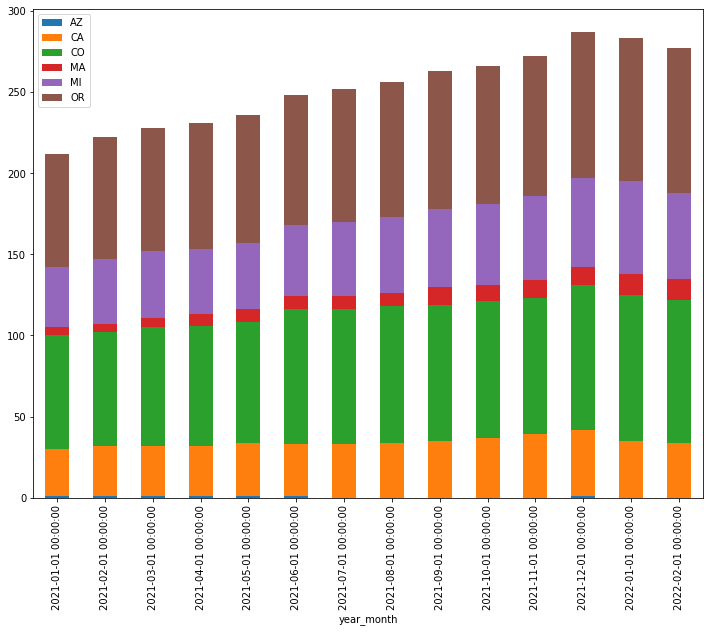

In [35]:
state_count = final_df[['location_state','location_id','year_month']].groupby(['location_state','year_month']).count().unstack().T.reset_index()
state_count.index = pd.to_datetime(state_count['year_month'])

ax = state_count.plot(kind='bar', stacked=True,figsize = (12,9))
ax.legend(loc = 2)

# Distribution of margin by states

In [36]:
# distribution of margin
margin_distr = final_df.groupby(['location_state','year_month'])['margin_perc'].describe().reset_index()
margin_distr['year_month'] = pd.to_datetime(margin_distr['year_month'])

In [37]:
margin_distr

,location_state,year_month,count,mean,std,min,25%,50%,75%,max
0,AZ,2021-01-01,1.0,0.484905,NaN,0.484905,0.484905,0.484905,0.484905,0.484905
1,AZ,2021-02-01,1.0,0.531077,NaN,0.531077,0.531077,0.531077,0.531077,0.531077
2,AZ,2021-03-01,1.0,0.491525,NaN,0.491525,0.491525,0.491525,0.491525,0.491525
3,AZ,2021-04-01,1.0,0.479615,NaN,0.479615,0.479615,0.479615,0.479615,0.479615
4,AZ,2021-05-01,1.0,0.461538,NaN,0.461538,0.461538,0.461538,0.461538,0.461538
...,...,...,...,...,...,...,...,...,...,...
72,OR,2021-10-01,85.0,0.476722,0.163876,-0.769251,0.441512,0.491600,0.560834,0.699340
73,OR,2021-11-01,86.0,0.480804,0.077651,0.108866,0.443298,0.485250,0.544177,0.655075
74,OR,2021-12-01,90.0,0.484259,0.108134,-0.157890,0.449223,0.502140,0.545464,0.694934
75,OR,2022-01-01,88.0,0.503684,0.079666,0.146675,0.465646,0.518939,0.552467,0.772858


In [ ]:
#margin_distr.to_csv('monthly_margin%_distribution_by_state.csv')

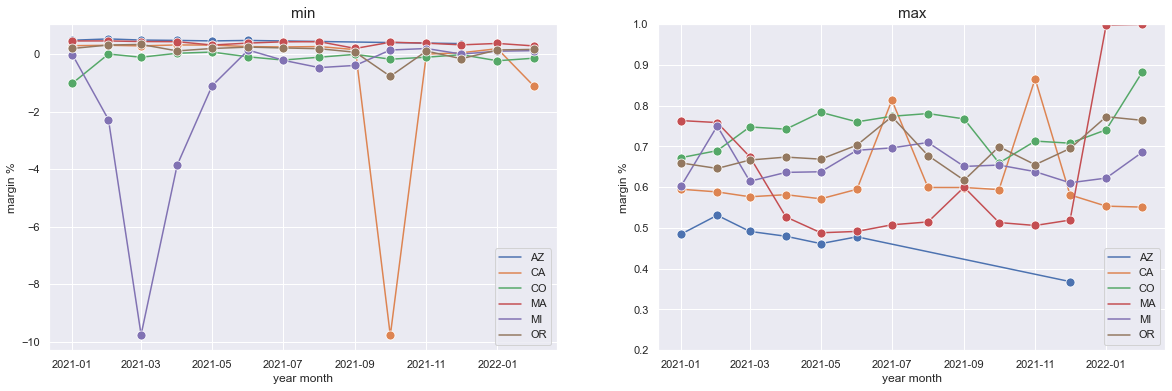

In [64]:
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr, x="year_month", y="min", hue="location_state",marker= 'o', markersize=9,ax=ax[0])
ax[0].legend(loc = 4)
ax[0].set_title("min", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
sns.lineplot(data=margin_distr, x="year_month", y="max", hue="location_state",marker= 'o', markersize=9,ax=ax[1])
ax[1].legend(loc = 4)
ax[1].set_title("max", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
ax[1].set(ylim=(0.2, 1))
sns.set(rc={'figure.figsize':(20,6)})


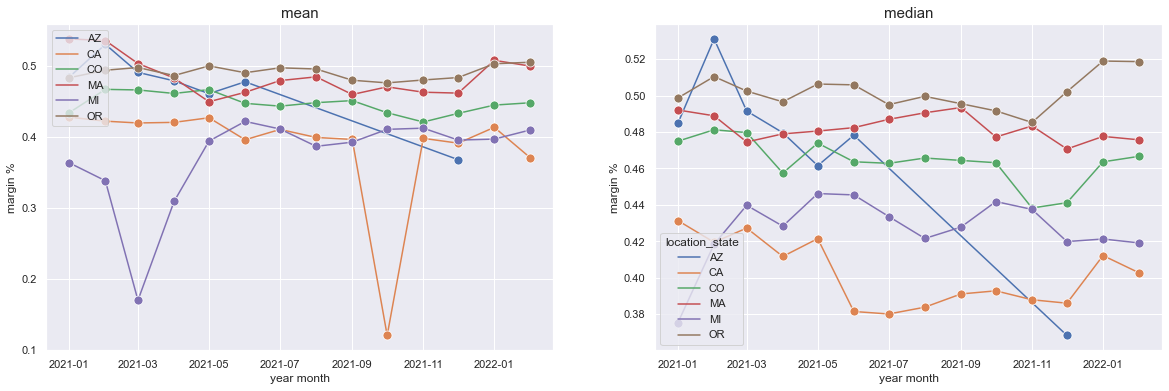

In [63]:
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr, x="year_month", y="mean", hue="location_state",marker= 'o', markersize=9,ax=ax[0])

ax[0].set_title("mean", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
ax[0].legend(loc = 2)
sns.lineplot(data=margin_distr, x="year_month", y="50%", hue="location_state",marker= 'o', markersize=9,ax=ax[1])

ax[1].set_title("median", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
sns.set(rc={'figure.figsize':(20,6)})


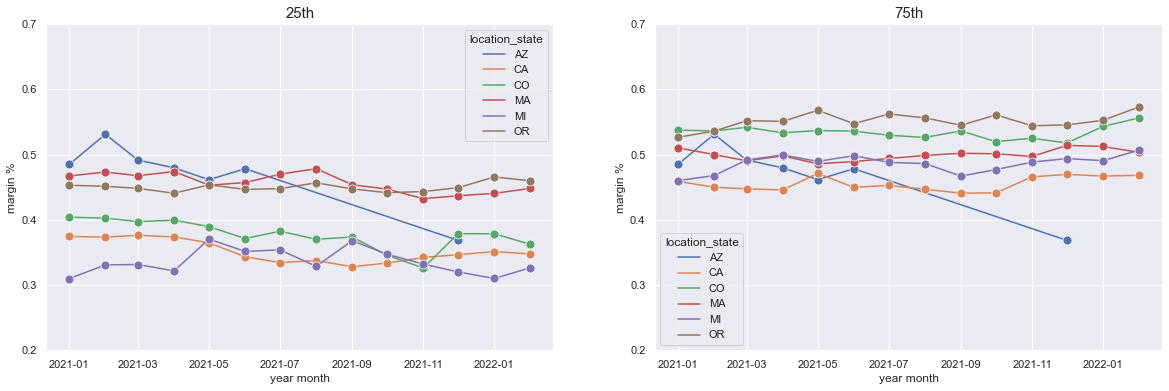

In [41]:
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr, x="year_month", y="25%", hue="location_state",marker= 'o', markersize=9,ax=ax[0])
ax[0].set(ylim=(0.2, 0.7))
ax[0].set_title("25th", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
sns.lineplot(data=margin_distr, x="year_month", y="75%", hue="location_state",marker= 'o', markersize=9,ax=ax[1])
ax[1].set(ylim=(0.2, 0.7))
ax[1].set_title("75th", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
sns.set(rc={'figure.figsize':(20,6)})


# Inventory

In [43]:
def pre_process_inv_df(df_inv,loc_id,loc_state):
    if 'costPerGram' in df_inv.columns:
        df_inv_to_merge = df_inv[['sku','quantity','cost','costPerGram']]
        df_inv_to_merge = df_inv_to_merge.assign(**{"cost_final": lambda df_: df_['cost'].fillna(df_['costPerGram'])})
        #set unit to dollar
        df_inv_to_merge['cost_final'] = df_inv_to_merge['cost_final'] / 100
    else:
        df_inv_to_merge = df_inv[['sku','quantity','cost']]
        df_inv_to_merge = df_inv_to_merge.assign(**{"cost_final": lambda df_: df_['cost']})
        #set unit to dollar
        df_inv_to_merge['cost_final'] = df_inv_to_merge['cost_final'] / 100
        
    # get each SKU's medium cost price across all inventory entries
    med_sku_price = df_inv_to_merge[['sku','cost_final']].groupby(['sku']).median().reset_index()
    # trim high cost items
    df_non_high_cost =  med_sku_price[med_sku_price['cost_final'] <= 500]

    # get each SKU's total quantity
    total_sku_quantity = df_inv_to_merge[['sku','quantity']].groupby(['sku']).sum().reset_index()
    total_sku_quantity_trim = total_sku_quantity[total_sku_quantity['quantity'] <= 10000]
    # calculate inventory
    total_inv_df = df_non_high_cost.merge(total_sku_quantity_trim,on = 'sku',how = 'inner')
    #calculate coverage
    num_sku = total_inv_df.shape[0]
    coverage = total_inv_df.shape[0] / df_inv_to_merge['sku'].nunique()
    non_zero_cost_perc = 1- ((total_inv_df[(total_inv_df['cost_final'] == 0)].shape[0]) / total_inv_df.shape[0])
    inventory = np.nansum(total_inv_df['quantity'] * total_inv_df['cost_final'])
    final_df = pd.DataFrame([loc_id,loc_state,inventory,num_sku,coverage,non_zero_cost_perc]).T
    return final_df
    
    
    
    

In [44]:
inv_res = []
for company_id, location_id, location_state, sa_df, inv_df in tqdm(company_location_dataframes):
    if len(sa_df) == 0:
        continue
    inv_res.append(pre_process_inv_df(inv_df, location_id, location_state))
    

100%|██████████| 327/327 [00:01<00:00, 177.32it/s]


In [45]:
inv_res_df = pd.concat(inv_res).reset_index(drop=True)
inv_res_df.columns = ['loc_id','loc_state','inventory','num_sku_in_inventory','coverage','non_zero_cost_perc']

In [46]:
inv_res_df['inventory'] = inv_res_df['inventory'].astype('float')
inv_res_df['num_sku_in_inventory'] = inv_res_df['num_sku_in_inventory'].astype('float')
inv_res_df['coverage'] = inv_res_df['coverage'].astype('float')
inv_res_df['non_zero_cost_perc'] = inv_res_df['non_zero_cost_perc'].astype('float')

In [47]:
inv_res_df.describe()


,inventory,num_sku_in_inventory,coverage,non_zero_cost_perc
count,3.040000e+02,304.000000,304.000000,304.000000
mean,1.899981e+05,828.493421,0.999633,0.985681
std,2.452254e+05,763.837014,0.001353,0.048439
min,4.770400e+02,10.000000,0.989130,0.620253
25%,6.199139e+04,413.500000,1.000000,0.998404
50%,1.000188e+05,674.500000,1.000000,1.000000
75%,2.065643e+05,1009.250000,1.000000,1.000000
max,1.801323e+06,7395.000000,1.000000,1.000000


In [48]:
inv_res_df

,loc_id,loc_state,inventory,num_sku_in_inventory,coverage,non_zero_cost_perc
0,yxhFg37pDhFC5MTvb,OR,9.594648e+04,581.0,1.000000,1.000000
1,CKhppABTnNSm5iTGd,OR,1.258428e+05,914.0,1.000000,1.000000
2,Q2kMvxBHw5BF4acj3,CO,4.361176e+04,412.0,0.997579,0.910194
3,9gbfoaHTCZkrduAtm,OR,6.373854e+04,866.0,1.000000,1.000000
4,TpetsriCnhipdAvdb,CO,1.362455e+05,534.0,0.990724,1.000000
...,...,...,...,...,...,...
299,BcggJ8dJgf6dG4HD6,CO,4.628958e+03,79.0,1.000000,0.620253
300,FwZYGEaYJRNwfrCLc,CA,8.759666e+04,297.0,1.000000,1.000000
301,YqRqN3SYekbMdP37Q,MI,6.809036e+05,1969.0,1.000000,0.997461
302,NMJ7s9vz56pXAWXmL,CA,2.419085e+05,941.0,1.000000,1.000000


# inventory TO

In [49]:
cogs_3m = final_df[final_df['year_month'].isin(['2021-12','2021-11','2022-01'])]

In [50]:
loc_cogs_3m_df = cogs_3m[['costInDollars','location_id']].groupby(['location_id']).sum().reset_index()

In [51]:
loc_cogs_3m_df.columns = ['loc_id','costInDollars']

In [52]:
j = loc_cogs_3m_df.merge(inv_res_df,on = 'loc_id',how = 'inner')

In [53]:
j['to'] = j['costInDollars'] / j['inventory'] * 4

In [54]:
j.describe()

,costInDollars,inventory,num_sku_in_inventory,coverage,non_zero_cost_perc,to
count,2.930000e+02,2.930000e+02,293.000000,293.000000,293.000000,293.000000
mean,3.558037e+05,1.950645e+05,848.389078,0.999657,0.985391,8.537651
std,4.680687e+05,2.482334e+05,769.966388,0.001232,0.049154,11.502279
min,1.080000e+02,4.770400e+02,10.000000,0.990509,0.620253,0.003605
25%,8.067056e+04,6.304567e+04,426.000000,1.000000,0.998342,4.085174
50%,2.145893e+05,1.029226e+05,688.000000,1.000000,1.000000,6.988779
75%,3.825784e+05,2.106313e+05,1049.000000,1.000000,1.000000,11.072419
max,3.236255e+06,1.801323e+06,7395.000000,1.000000,1.000000,179.451115


In [55]:
# distribution of margin
to_distr = j.groupby(['loc_state'])['to'].describe().reset_index()
coverage_distr = j.groupby(['loc_state'])['non_zero_cost_perc'].describe().reset_index()

Text(0, 0.5, 'inventory TO')

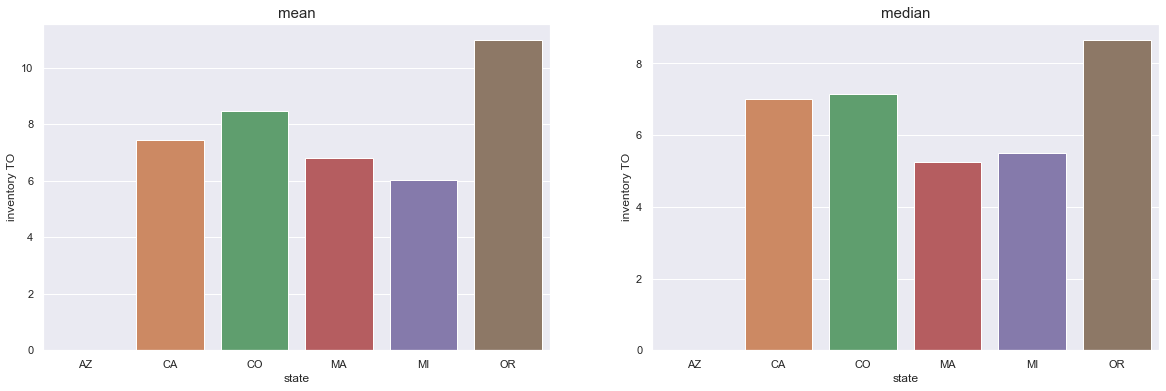

In [56]:
fig, ax =plt.subplots(1,2)
sns.barplot(data=to_distr, x="loc_state", y="mean",ax=ax[0])

ax[0].set_title("mean", fontsize=15)
ax[0].set_xlabel ("state")
ax[0].set_ylabel ("inventory TO")
sns.barplot(data=to_distr, x="loc_state", y="50%",ax=ax[1])

ax[1].set_title("median", fontsize=15)
ax[1].set_xlabel ("state")
ax[1].set_ylabel ("inventory TO")



Text(0, 0.5, 'inventory TO')

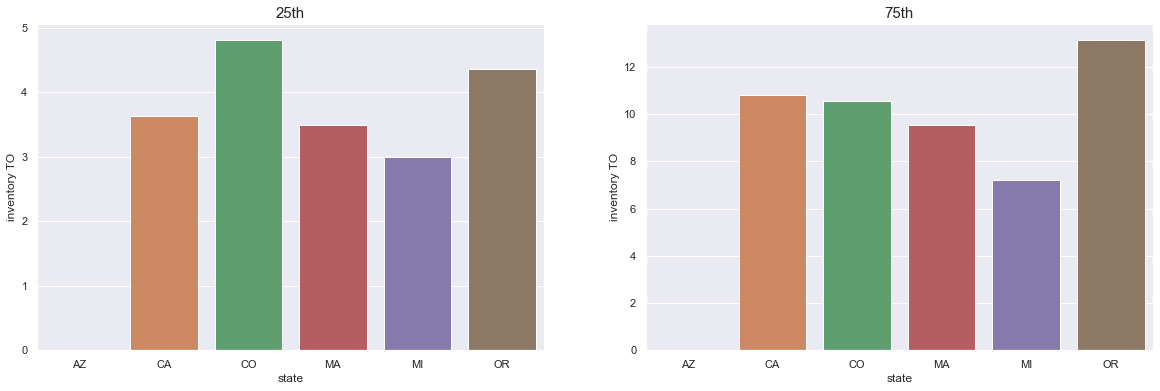

In [57]:
fig, ax =plt.subplots(1,2)
sns.barplot(data=to_distr, x="loc_state", y="25%",ax=ax[0])

ax[0].set_title("25th", fontsize=15)
ax[0].set_xlabel ("state")
ax[0].set_ylabel ("inventory TO")
sns.barplot(data=to_distr, x="loc_state", y="75%",ax=ax[1])

ax[1].set_title("75th", fontsize=15)
ax[1].set_xlabel ("state")
ax[1].set_ylabel ("inventory TO")



Text(0, 0.5, 'inventory TO')

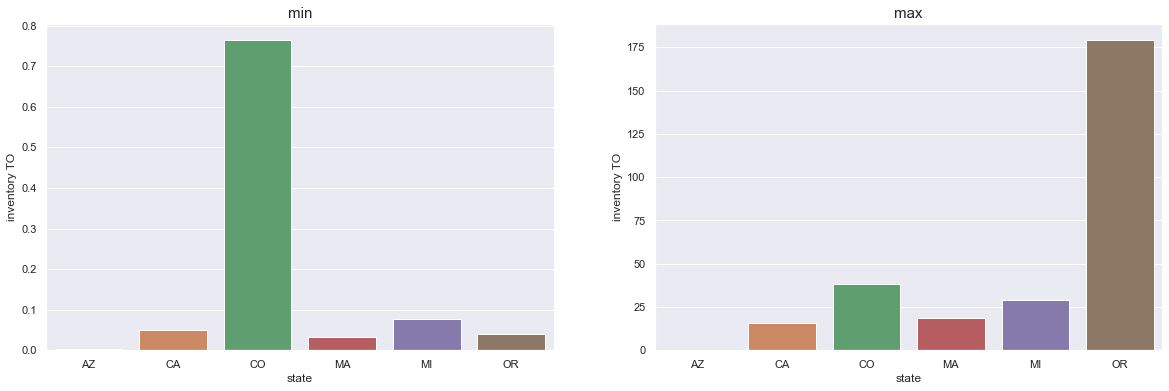

In [58]:
fig, ax =plt.subplots(1,2)
sns.barplot(data=to_distr, x="loc_state", y="min",ax=ax[0])

ax[0].set_title("min", fontsize=15)
ax[0].set_xlabel ("state")
ax[0].set_ylabel ("inventory TO")
sns.barplot(data=to_distr, x="loc_state", y="max",ax=ax[1])

ax[1].set_title("max", fontsize=15)
ax[1].set_xlabel ("state")
ax[1].set_ylabel ("inventory TO")

